# Imports & Constants

In [1]:
import pandas as pd
import os
from rdflib import Graph, Namespace
from collections import defaultdict
from tqdm.notebook import tqdm
import json

VIOLATION_LIST_FILE = "./json/violation_list.json" # path to store the violation list
STUDY_CSV_FILE = "./csv/study.csv" # path to store the tabluraized study csv file
STUDY_TTL_PATH = './ttl/study.ttl' # contains the actual study data
OMICS_MODEL_TTL_PATH = './ttl/omics_model.ttl' # contains the ontology
OMICS_MODEL_UNION_VIOLATION_EXEMPLAR_TTL_PATH = './ttl/omics_model_union_violation_exemplar.ttl' # contains the union of the ontology and the violation exemplars
VIOLATION_REPORT_TTL_PATH = './ttl/violation_report.ttl' # contains the shacl violation test case result
EXEMPLAR_EDGE_COUNT_DICT_PATH = './json/exemplar_edge_count_dict.json' # contains the nested dict of exemplar edge counts
FOCUS_NODE_EXEMPLAR_DICT_PATH = './json/focus_node_exemplar_dict.json' # contains the dict of exemplars per focus node
EXEMPLAR_FOCUS_NODE_DICT_PATH = './json/exemplar_focus_node_dict.json' # contains the dict of focus nodes per exemplar

# Read & Parse Graphs

In [2]:
print("Reading study graph...")
study_g = Graph()
study_g.parse(STUDY_TTL_PATH, format="ttl")

print("Reading violations graph...")
violations_g = Graph()
violations_g.parse(VIOLATION_REPORT_TTL_PATH, format="ttl")

Reading study graph...
Reading violations graph...


<Graph identifier=Nfae2ee43a79b431fa55aa74ce80085d5 (<class 'rdflib.graph.Graph'>)>

# Give Enumarting Names to Unnamed NodeShapes
example: [] a sh:NodeShape -> NodeShape1 a sh:NodeShape
etc
this could be done with rdflib but then when storing the graph to a .ttl file it would automatically mess with the namespaces and remove unused ones
so until these names are provided by BI, we decided to do simple string replacement

<span style="color:orange">Careful: If the omics_model.ttl contains [] anywhere else, e.g., in a label, it will also be replaced there!</span>

In [3]:
import os

# Read the input file
with open(OMICS_MODEL_TTL_PATH, 'r') as file:
    data = file.read()

# Define backup file path
backup_file_path = OMICS_MODEL_TTL_PATH + ".bak"

# Ensure the output directory exists
os.makedirs(os.path.dirname(OMICS_MODEL_TTL_PATH), exist_ok=True)

# store backup file
with open(backup_file_path, 'w') as file:
    file.write(data)

# Initialize the counter
counter = 1

# Prepend '@prefix cns: <http://custom_node_shapes/> .'
data = "@prefix cns: <http://customnamespace.com/> .\n" + data

# Replace occurrences of [] with NodeShape{counter}
while "[]" in data:
    data = data.replace("[]", f"cns:NodeShape{counter}", 1)
    counter += 1

# Write the updated string to the new file
with open(OMICS_MODEL_TTL_PATH, 'w') as file:
    file.write(data)

# Differentiate NaN Cases - Predicate cannot Exist on Class vs. Predicate is Missing vs. Predicta Exists Even Though It Cannot
A node can have an edge if

s1 a sh:NodeShape

s1 sh:targetClass node

s1 sh:property s2

s2 a sh:PropertyShape

s2 sh:Path edge

OR 

(
node rdfs:subClassOf s3
AND
s3 can have the edge
)

In [4]:
from rdflib import Graph
from rdflib.namespace import Namespace
import networkx as nx
import matplotlib.pyplot as plt

# read ontology into a graph
ontology_g = Graph()
ontology_g.parse(OMICS_MODEL_TTL_PATH, format="ttl")

# take namespace prefix for sh and omics from the graph
sh = Namespace("http://www.w3.org/ns/shacl#")
omics = Namespace("http://data.boehringer.com/ontology/omics#")
owl = Namespace("http://www.w3.org/2002/07/owl#")

# define prefixes and corresponding namespaces
prefixes = {
    "sh": "http://www.w3.org/ns/shacl#",
    "omics": "http://data.boehringer.com/ontology/omics#",
    "owl": "http://www.w3.org/2002/07/owl#"
}

def convert_to_prefixed(graph, uri):
    """Convert a URI to its prefixed form using a rdflib graph's namespace manager."""
    prefix, namespace, name = graph.namespace_manager.compute_qname(uri)
    return f"{prefix}:{name}"

def select_direct_possible_edges(node):
    select_statement = """
    SELECT ?edge
    WHERE {
        ?ns a sh:NodeShape .
        ?ns sh:targetClass omics:%s .
        ?ns sh:property ?ps .
        ?ps a sh:PropertyShape .
        ?ps sh:path ?edge .
    }
    """ % node
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_direct_parents(node):
    select_statement = """
    SELECT ?parent
    WHERE {
        omics:%s rdfs:subClassOf ?parent .
    }
    """ % node
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_direct_children(node):
    select_statement = """
    SELECT ?child
    WHERE {
        ?child rdfs:subClassOf omics:%s .
    }
    """ % node
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_roots():
    select_statement = """
    SELECT ?root
    WHERE {
        ?root rdfs:subClassOf owl:Thing .
    }
    """
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_root_classes():
    select_statement = """
    SELECT ?class
    WHERE {
        ?class a owl:Class .
        FILTER NOT EXISTS { ?class rdfs:subClassOf ?parent . }
    }
    """
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore


# use the functions
roots = select_root_classes()
edges = select_direct_possible_edges('PrimaryCellSpecimen')
parents = select_direct_parents('BiopsySpecimen')
children = select_direct_children('BiopsySpecimen')

print('Roots:', roots)
print('Edges:', edges)
print('Parents:', parents)
print('Children:', children)

Roots: ['omics:Thing', 'omics:KeyValueHolder', 'omics:ReferenceData']
Edges: ['omics:hasCellType', 'omics:hasSourceTissue', 'omics:hasSourceCellType']
Parents: ['omics:Specimen']
Children: ['omics:PDXSpecimen', 'omics:PrimaryCellSpecimen']


In [5]:
class OntologyTree:
    def __init__(self):
        self.tree = {}

    def add_node(self, node, edges, children):
        if node not in self.tree:
            self.tree[node] = {'edges': edges, 'children': children}

    def add_child(self, parent, child):
        if parent in self.tree:
            self.tree[parent]['children'].append(child)
        else:
            self.tree[parent] = {'edges': [], 'children': [child]}

def aggregate_edges(node, tree):
    edges = set(tree[node]['edges'])
    queue = [parent_node for parent_node in tree if node in tree[parent_node]['children']]
    while queue:
        parent_node = queue.pop(0)
        edges |= set(tree[parent_node]['edges'])
        queue += [grand_parent for grand_parent in tree if parent_node in tree[grand_parent]['children']]
    return edges

def create_aggregated_edges_dict(tree):
    agg_edges_dict = {}
    for node in tree.keys():
        agg_edges_dict[node] = aggregate_edges(node, tree)
    return agg_edges_dict

def convert_to_full_uri(graph, abbreviated_uri):
    """Converts a prefixed URI to a full URI using a rdflib graph's namespace manager."""
    prefix, uri = abbreviated_uri.split(':')
    namespace = graph.namespace_manager.store.namespace(prefix)
    return namespace + uri

def remove_prefix(uri):
    if ':' in uri:
        return uri.split(':', 1)[1]
    return uri

def build_tree(root_nodes, ontology_tree):
    queue = root_nodes
    while queue:
        current_node = queue.pop(0)
        unprefixed_node = remove_prefix(current_node)
        edges = select_direct_possible_edges(unprefixed_node)
        children = select_direct_children(unprefixed_node)

        ontology_tree.add_node(current_node, edges, children)

        for child in children:
            queue.append(child)


In [6]:
roots = select_root_classes()
ontology_tree = OntologyTree()
build_tree(roots, ontology_tree)
agg_edges_dict = create_aggregated_edges_dict(ontology_tree.tree)

In [7]:
full_uri = convert_to_full_uri(ontology_g, "omics:hasCellType")
print(full_uri)  # Outputs: http://[blabla...]/omics:hasCellType


http://data.boehringer.com/ontology/omics/hasCellType


In [8]:
def select_all_focus_nodes_and_classes(graph):
    select_statement = """
    SELECT ?node ?class
    WHERE {
        ?node a ?class .
    }
    """
    results = graph.query(select_statement)
    focus_nodes_classes_dict = {str(result[0]): str(result[1]) for result in results}
    return focus_nodes_classes_dict


focus_nodes_class_dict = select_all_focus_nodes_and_classes(study_g)

In [9]:
x = focus_nodes_class_dict['http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_545']
print(x) # this returns http://data.boehringer.com/ontology/omics/TranscriptOmicsSample
print(convert_to_prefixed(ontology_g, x)) # should return omics:TranscriptOmicsSample
print(agg_edges_dict[convert_to_prefixed(ontology_g, x)])


http://data.boehringer.com/ontology/omics/TranscriptOmicsSample
omics:TranscriptOmicsSample
{'omics:hasSequencingProtocol', 'omics:sampleOrder', 'omics:isPartOfSampleSet', 'omics:hasExclusionReason', 'omics:comment', 'omics:sourceId', 'omics:isMeasuredOnPlatform', 'omics:hasKeyValue', 'omics:hasStrandedness', 'omics:id', 'omics:isDerivedFromSpecimen', 'omics:isPartOfStudy', 'omics:hasRIN', 'omics:isPreparedByLibrary', 'omics:processingDate', 'omics:isExcluded', 'omics:isProcessedByOrganisation', 'omics:name'}


# Tabularize & Join Study + Violations Graphs

In [10]:
from rdflib import Graph, Namespace
from rdflib.namespace import NamespaceManager
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm

SH = Namespace("http://www.w3.org/ns/shacl#")

def count_violations(violations: Graph):
    d_focus_node_d_source_shape_counts = defaultdict(lambda: defaultdict(int))
    d_violation_focus_node = defaultdict((str))
    d_violation_source_shape = defaultdict((str))
    violation_list = []

    for s, p, o in tqdm(violations, desc="Processing Graph Once"):
        if p == SH.sourceShape:
            d_violation_source_shape[str(s)] = str(o)
            violation_list += [str(o)]
        elif p == SH.focusNode:
            d_violation_focus_node[str(s)] = str(o)

    # for key in violation_focus_node dict
    for key in tqdm(d_violation_focus_node, desc="Going Over Violation Instances"):
        # init with 1 or add 1 if already exists
        d_focus_node_d_source_shape_counts[d_violation_focus_node[key]][d_violation_source_shape[key]] += 1

    violation_list = list(set(violation_list))
    return d_focus_node_d_source_shape_counts, violation_list


def save_violation_list(violation_list):
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)  


def create_study_dataframe(study: Graph, d_focus_node_d_source_shape_counts, focus_nodes_class_dict, agg_edges_dict):
    # for convenience
    pre = lambda x: convert_to_prefixed(ontology_g, str(x))

    # create an empty study_df, fill the violation counts
    study_df = pd.DataFrame(d_focus_node_d_source_shape_counts).T.fillna(0)

    count_not_skipped, count_skipped, count_allowed, count_not_allowed_exists, count_not_allowed_empty = 0, 0, 0, 0, 0

    # iterate all study triples
    for s, p, o in tqdm(study, desc="Processing study"):
        # if s is not in d_focus_node_d_source_shape_counts, continue as it is not a focus node
        if str(s) not in d_focus_node_d_source_shape_counts:
            count_skipped += 1
            continue
        count_not_skipped += 1

        # if p is not in study_df.columns, add it and set it to EdgeNotPresent for all rows because so far there has not been a value for it for anything, and future values will overwrite it anyway
        if str(p) not in study_df.columns:
            study_df[str(p)] = "EdgeNotPresent"

        # if object is empty throw exception and print details
        if str(o) == "":
            print("empty object for " + str(s) + " " + str(p))
            raise Exception("empty object for " + str(s) + " " + str(p))

        # get class of focus node
        focus_node_class = focus_nodes_class_dict.get(str(s), None)
        assert focus_node_class is not None, f"The focus_node_class for {str(s)} was None, but expected a value."
        # get allowed edges
        focus_node_edges = agg_edges_dict.get(convert_to_prefixed(ontology_g, focus_node_class), set())
        assert len(focus_node_edges) > 0

        # if edge is allowed (and object is present otherwise we wouldn't get here), set value study_df.at[str(s), str(p)] = str(o)
        if pre(p) in focus_node_edges:
            study_df.at[str(s), str(p)] = str(o)
            count_allowed += 1
        # if edge is not allowed, and there is no object, set value study_df.at[str(s), str(p)] = "EdgeNotPresent"
        elif pre(p) not in focus_node_edges and str(o) == "":
            study_df.at[str(s), str(p)] = "EdgeNotPresent"
            count_not_allowed_empty += 1
        # if edge is not allowed, and there is an object, set value study_df.at[str(s), str(p)] = "InvalidEdgeWUnexpectedEdgeWithDataithData: str(o)"
        elif pre(p) not in focus_node_edges and str(o) != "":
            # study_df.at[str(s), str(p)] = "UnexpectedEdgeWithData: " + str(o)
            study_df.at[str(s), str(p)] = str(o)
            count_not_allowed_exists += 1
        else:
            raise Exception("should not happen: " + str(s) + " " + str(p) + " " + str(o))

    print(f"count_skipped = {count_skipped}")
    print(f"count_not_skipped = {count_not_skipped}")
    print(f"count_allowed = {count_allowed}")
    print(f"count_not_allowed_exists = {count_not_allowed_exists}")
    print(f"count_not_allowed_empty = {count_not_allowed_empty}")

    assert study_df.isin(['']).sum().sum() == 0
    assert study_df.isnull().sum().sum() == 0, f"study_df.isnull().sum().sum() = {study_df.isnull().sum().sum()}"

    # add focus_node column, set it to the study_df.index, and move it to the very left of the dataframe
    study_df['focus_node'] = study_df.index
    cols = study_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]  # move the last column to the first
    study_df = study_df[cols]

    return study_df


def save_study_dataframe(study_df):
    study_df.to_csv(STUDY_CSV_FILE)


def tabularize_graphs(study: Graph, violations: Graph):
    print('study graph triples:', len(study))  # type: ignore
    print('violations graph triples:', len(violations))  # type: ignore
    d_focus_node_d_source_shape_counts, violation_list = count_violations(violations)
    save_violation_list(violation_list)
    study_df = create_study_dataframe(study, d_focus_node_d_source_shape_counts, focus_nodes_class_dict, agg_edges_dict)
    save_study_dataframe(study_df)
    return d_focus_node_d_source_shape_counts


d_focus_node_d_source_shape_counts = tabularize_graphs(study_g, violations_g)

study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()


study graph triples: 97794
violations graph triples: 286592


Processing study: 100%|██████████| 97794/97794 [00:01<00:00, 75484.80it/s]


count_skipped = 19186
count_not_skipped = 78608
count_allowed = 50295
count_not_allowed_exists = 28313
count_not_allowed_empty = 0


,focus_node,http://data.boehringer.com/ontology/omics/afb51f95-5b17-45a4-b62d-c58f4998f930,http://data.boehringer.com/ontology/omics/0c2600b5-30b2-40c7-917a-b402e73f55ae,http://data.boehringer.com/ontology/omics/248e9792-8549-4e0d-8665-06c42aff8ffc,http://data.boehringer.com/ontology/omics/9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,http://data.boehringer.com/ontology/omics/38c0a1c7-1c92-489a-a22e-87f5335ccb1a,http://data.boehringer.com/ontology/omics/af998a22-f11b-43ea-b0ac-44e728baeafb,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasSequencingProtocol,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasStrandedness,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isMeasuredOnPlatform,...,http://data.boehringer.com/ontology/omics/keywords,http://data.boehringer.com/ontology/omics/isSequencedForIndication,http://data.boehringer.com/ontology/omics/sourceStudyId,http://data.boehringer.com/ontology/omics/externalStudyId,http://data.boehringer.com/ontology/omics/studyId,http://data.boehringer.com/ontology/omics/hasStudyType,http://data.boehringer.com/ontology/omics/technicalStudyTitle,http://data.boehringer.com/ontology/omics/hasContactScientist,http://data.boehringer.com/ontology/omics/hasContactCompBio,http://data.boehringer.com/ontology/omics/sequencingDate
http://data.boehringer.com/uuid/Donor/9abcf968-791a-4520-b650-2439b9237515,http://data.boehringer.com/uuid/Donor/9abcf968...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/Donor/4b2b6b89-7e27-4475-a0e6-e6638541de43,http://data.boehringer.com/uuid/Donor/4b2b6b89...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/PrimaryCellSpecimen/3c0bedfd-345a-4b5a-8528-abe0516a4232,http://data.boehringer.com/uuid/PrimaryCellSpe...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/PrimaryCellSpecimen/f5f9d112-0e74-4363-9b71-351a541172d9,http://data.boehringer.com/uuid/PrimaryCellSpe...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_104,http://data.boehringer.com/uuid/TranscriptOmic...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent


# Unit Tests for Violation Counting

In [11]:
import unittest
from rdflib import Graph, Literal, Namespace, BNode, URIRef

SH = Namespace("http://www.w3.org/ns/shacl#")

class TestCountViolations(unittest.TestCase):
    def setUp(self):
        self.violations = Graph()

    def test_count_violations_node_with_multiple_and_node_with_double(self):
        self.focusNode1 = BNode()
        self.focusNode2 = BNode()
        self.sourceShape1 = Literal('shape1')
        self.sourceShape2 = Literal('shape2')
        self.violation1 = BNode()
        self.violation2 = BNode()
        self.violation3 = BNode()
        self.violation4 = BNode()

        # Add triples to the violations graph
        self.violations.add((self.violation1, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation1, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation2, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation2, SH.sourceShape, self.sourceShape2))

        self.violations.add((self.violation3, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation3, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation4, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation4, SH.sourceShape, self.sourceShape1))
        violation_counts, violation_list = count_violations(self.violations)
        expected_counts = {
            str(self.focusNode1): {str(self.sourceShape1): 2},
            str(self.focusNode2): {str(self.sourceShape2): 1, str(self.sourceShape1): 1}
        }
        expected_list = [str(self.sourceShape1), str(self.sourceShape2)] 
        
        self.assertEqual(violation_counts, expected_counts)
        self.assertEqual(set(violation_list), set(expected_list))  # Use set to ignore order

    def test_count_violations_basic(self):
        self.focusNode1 = BNode()
        self.focusNode2 = BNode()
        self.focusNode3 = BNode()
        self.sourceShape1 = Literal('shape1')
        self.sourceShape2 = Literal('shape2')
        self.sourceShape3 = Literal('shape3')
        self.violation1 = BNode()
        self.violation2 = BNode()
        self.violation3 = BNode()

        # Add triples to the violations graph
        self.violations.add((self.violation1, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation1, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation2, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation2, SH.sourceShape, self.sourceShape2))

        self.violations.add((self.violation3, SH.focusNode, self.focusNode3))
        self.violations.add((self.violation3, SH.sourceShape, self.sourceShape3))

        violation_counts, violation_list = count_violations(self.violations)
        expected_counts = {
            str(self.focusNode1): {str(self.sourceShape1): 1},
            str(self.focusNode2): {str(self.sourceShape2): 1},
            str(self.focusNode3): {str(self.sourceShape3): 1}
        }
        expected_list = [str(self.sourceShape1), str(self.sourceShape2), str(self.sourceShape3)] 
        
        self.assertEqual(violation_counts, expected_counts)
        self.assertEqual(set(violation_list), set(expected_list))  # Use set to ignore order

suite = unittest.TestLoader().loadTestsFromTestCase(TestCountViolations)
unittest.TextTestRunner().run(suite)


Going Over Violation Instances: 100%|██████████| 4/4 [00:00<?, ?it/s]
.
----------------------------------------------------------------------
Ran 2 tests in 0.010s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Abbreviation using QNames

In [12]:
import pandas as pd
from rdflib import Graph
from rdflib.namespace import split_uri

def namespace_in_nsm(nsm, namespace):
    """
    Checks if a given namespace is in the provided NamespaceManager.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to check
    namespace (str): the namespace to look for in the NamespaceManager

    Returns:
    bool: True if the namespace is in the NamespaceManager, False otherwise
    """
    for prefix, ns in nsm.namespaces():
        if str(ns) == str(namespace):
            return True
    return False

def get_qname(nsm, uri):
    """
    Returns a QName for a given URI if its namespace is in the provided NamespaceManager.
    If the namespace isn't found in the NamespaceManager, it returns the original URI.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to use
    uri (str): the URI to transform into a QName

    Returns:
    str: a QName if the namespace of the URI is in the NamespaceManager, the original URI otherwise
    """
    namespace, name = split_uri(uri)
    if namespace_in_nsm(nsm, namespace):
        try:
            prefix, _, _ = nsm.compute_qname(uri)
            return f"{prefix}:{name}"
        except Exception as e:
            return uri
    else:
        return uri

def abbreviate_using_namespaces(study_graph: Graph, violations_graph: Graph):
    """
    Replaces URIs in a DataFrame and a list of violations with QNames if their namespaces
    are found in two provided RDF graphs. Saves the updated DataFrame and the list back to disk.

    Parameters:
    study_graph (Graph): the first RDF graph to use for namespaces
    violations_graph (Graph): the second RDF graph to use for namespaces
    """

    # load violation_list
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_list = json.load(f)

    # read study_df tabularized data
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    # Create a new graph to combine namespaces
    combined_graph = Graph()

    # Get namespaces from both graphs and bind them to the combined graph
    for prefix, ns_uri in study_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    # Now use the NamespaceManager of the combined graph
    nsm_combined = NamespaceManager(combined_graph)

    # Change column names
    for col in study_df.columns:
        try:
            study_df.rename(columns={col: get_qname(nsm_combined, col)}, inplace=True)
        except:
            pass

    # Change indices and cell values
    for col in study_df.columns:
        for idx in study_df.index:
            try:
                study_df.loc[idx, col] = get_qname(nsm_combined, study_df.loc[idx, col])
            except:
                pass

    # change index
    for idx in study_df.index:
        try:
            study_df.rename(index={idx: get_qname(nsm_combined, str(idx))}, inplace=True)
        except:
            pass

    # change violation_list
    for i in range(len(violation_list)):
        try:
            violation_list[i] = get_qname(nsm_combined, violation_list[i])
        except:
            pass

    # store tabular graph as csv
    study_df.to_csv(STUDY_CSV_FILE)    

    # store violation_list as json
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)

abbreviate_using_namespaces(study_g, violations_g)

In [13]:
with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_list = json.load(f)

print('unique violations ('+str(len(violation_list))+'):\n')
print('\n'.join([str(v) for v in violation_list]))

unique violations (18):

omics:0c2600b5-30b2-40c7-917a-b402e73f55ae
omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform
omics:TranscriptOmicsSampleShape-hasSequencingProtocol
omics:OmicsStudyShape-hasContactScientist
omics:OmicsStudyShape-isSequencedForTherapeuticArea
omics:OmicsStudyShape-hasStudyType
omics:afb51f95-5b17-45a4-b62d-c58f4998f930
omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a
omics:af998a22-f11b-43ea-b0ac-44e728baeafb
omics:OmicsStudyShape-hasContactCompBio
omics:OmicsStudyShape-hasResponsibleSite
omics:TranscriptOmicsSampleShape-isPreparedByLibrary
omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9
omics:OmicsStudyShape-isSequencedForIndication
omics:OmicsStudyShape-isPartOfProject
omics:TranscriptOmicsSampleShape-hasStrandedness
omics:248e9792-8549-4e0d-8665-06c42aff8ffc
omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f


In [14]:
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

,focus_node,omics:afb51f95-5b17-45a4-b62d-c58f4998f930,omics:0c2600b5-30b2-40c7-917a-b402e73f55ae,omics:248e9792-8549-4e0d-8665-06c42aff8ffc,omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a,omics:af998a22-f11b-43ea-b0ac-44e728baeafb,omics:TranscriptOmicsSampleShape-hasSequencingProtocol,omics:TranscriptOmicsSampleShape-hasStrandedness,omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform,...,omics:keywords,omics:isSequencedForIndication,omics:sourceStudyId,omics:externalStudyId,omics:studyId,omics:hasStudyType,omics:technicalStudyTitle,omics:hasContactScientist,omics:hasContactCompBio,omics:sequencingDate
http://data.boehringer.com/uuid/Donor/9abcf968-791a-4520-b650-2439b9237515,http://data.boehringer.com/uuid/Donor/9abcf968...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/Donor/4b2b6b89-7e27-4475-a0e6-e6638541de43,http://data.boehringer.com/uuid/Donor/4b2b6b89...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/PrimaryCellSpecimen/3c0bedfd-345a-4b5a-8528-abe0516a4232,http://data.boehringer.com/uuid/PrimaryCellSpe...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/PrimaryCellSpecimen/f5f9d112-0e74-4363-9b71-351a541172d9,http://data.boehringer.com/uuid/PrimaryCellSpe...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_104,http://data.boehringer.com/uuid/TranscriptOmic...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent,EdgeNotPresent


# Compute Violation Embedding

Creating UMAP embedding... (this may take some time)
UMAP(n_neighbors=72, random_state=0, verbose=True)
Thu Aug 24 10:14:00 2023 Construct fuzzy simplicial set
Thu Aug 24 10:14:00 2023 Finding Nearest Neighbors
Thu Aug 24 10:14:00 2023 Building RP forest with 9 trees
Thu Aug 24 10:14:00 2023 NN descent for 12 iterations
	 1  /  12
	Stopping threshold met -- exiting after 1 iterations
Thu Aug 24 10:14:20 2023 Finished Nearest Neighbor Search
Thu Aug 24 10:14:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Aug 24 10:15:26 2023 Finished embedding
UMAP embedding created and saved to ./csv/study.csv


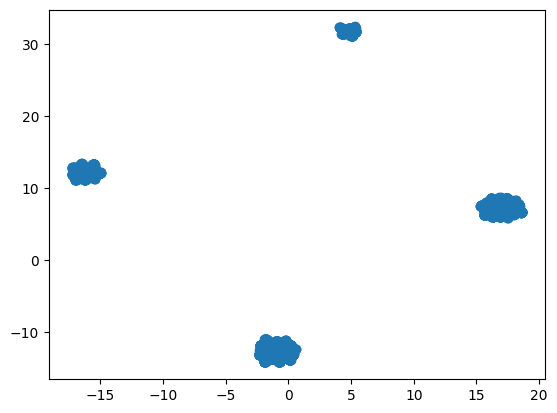

In [15]:
from matplotlib import pyplot as plt
import umap
import pandas as pd
import json
import numpy as np

from scipy.sparse import coo_matrix

def create_embedding():
    # read study.csv
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
    
    # read violation_list.json
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_columns = json.load(f)
    
    view_df = study_df[violation_columns]  # view of study dataframe with only violation columns

    print("Creating UMAP embedding... (this may take some time)")
    reducer = umap.UMAP(n_neighbors=int(np.sqrt(len(view_df))), min_dist=0.1, n_components=2, random_state=0, verbose=True)
    result = reducer.fit_transform(view_df)  # 2D projection

    # Check if the result is a tuple and unpack accordingly
    if isinstance(result, tuple):
        embedding, *_ = result
    else:
        embedding = result

    # Convert to dense numpy array if it's a sparse matrix
    if isinstance(embedding, coo_matrix):
        embedding = embedding.toarray()

    # Assuming that the embedding is now a NumPy array, based on the docstring
    study_df["x"] = embedding[:, 0]
    study_df["y"] = embedding[:, 1]

    study_df.to_csv(STUDY_CSV_FILE)
    print("UMAP embedding created and saved to", STUDY_CSV_FILE)


def plot_embedding():
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    plt.scatter(study_df["x"], study_df["y"])
    plt.show()

create_embedding()
plot_embedding()


# Replace URIs with Label Data

In [16]:
import pandas as pd
import json
from rdflib import URIRef

# list of label predicates in ascending order of priority
label_predicates = [
    # URIRef('http://data.boehringer.com/ontology/omics/hasValue'),
    # URIRef('http://data.boehringer.com/ontology/omics/name'),
    URIRef('http://www.w3.org/2004/02/skos/core#prefLabel')
]

# read tabularized graph .csv as a dataframe, and violations list .json as a list
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_columns = json.load(f)

# Create a new graph to combine namespaces
combined_graph = Graph()

# Get namespaces from both graphs and bind them to the combined graph
for prefix, ns_uri in study_g.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(prefix, ns_uri)

for prefix, ns_uri in violations_g.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(prefix, ns_uri)

# Now use the NamespaceManager of the combined graph
nsm_combined = NamespaceManager(combined_graph)

# create a dictionary of {s: o} pairs for translating source shapes to their labels
label_dict = {}
for label_predicate in label_predicates:
    temp_dict = {str(s): str(o) for s, p, o in study_g.triples((None, label_predicate, None))}
    # replace the temp_dict keys with their corresponding QNames
    temp_dict = {get_qname(nsm_combined, k): v for k, v in temp_dict.items()}
    # Update label_dict with temp_dict, overwriting existing keys
    label_dict.update(temp_dict)

# replace all column names, indices, and cell values in the dataframe with their corresponding labels
study_df.columns = [label_dict.get(col, col) for col in study_df.columns]
study_df.index = pd.Index([label_dict.get(idx, idx) for idx in study_df.index])
for col in study_df.columns:
    study_df[col] = study_df[col].apply(lambda x: label_dict.get(x, x))

# replace all dictionary keys and values with their corresponding labels
violation_columns = [label_dict.get(x, x) for x in violation_columns]

# store dataframe back to .csv and violations list back to .json
study_df.to_csv(STUDY_CSV_FILE)
with open(VIOLATION_LIST_FILE, 'w') as f:
    json.dump(violation_columns, f)


# Create Union of Ontology and Violation Report Exemplars

In [17]:
from rdflib import URIRef, RDFS

def replace_uris_with_labels(data, label_dict, data_type="graph"):
    if data_type == "graph":
        # Iterate through each triple
        for s, p, o in list(data.triples((None, None, None))):
            new_s = URIRef(label_dict.get(str(s), s))
            new_o = URIRef(label_dict.get(str(o), o))
            
            if new_s != s or new_o != o:
                data.remove((s, p, o))
                data.add((new_s, p, new_o))
                
    elif data_type == "dict":
        new_data = {}
        for key, values in data.items():
            new_key = label_dict.get(key, key)
            
            # If the values are in set form
            if isinstance(values, set):
                new_values = {label_dict.get(val, val) for val in values}
                
            # If the values are in dictionary form with concatenated string keys
            elif isinstance(values, dict):
                new_values = {}
                for po_str, count in values.items():
                    if '__' in po_str:
                        p, o = po_str.split('__')
                        new_p = label_dict.get(p, p)
                        new_o = label_dict.get(o, o)
                        new_po_str = f"{new_p}__{new_o}"
                        new_values[new_po_str] = count
                    else:
                        new_po_str = label_dict.get(po_str, po_str)
                        new_values[new_po_str] = count
            
            new_data[new_key] = new_values
            
        return new_data
    
    return data



def add_labels_to_graph(graph, label_dict):
    for uri, label in label_dict.items():
        graph.add((URIRef(uri), URIRef('http://www.w3.org/2004/02/skos/core#prefLabel'), Literal(label)))
    return graph

In [18]:
from rdflib import Graph
import json
from routers.utils import get_violation_report_exemplars

ontology_union_violation_exemplars_g, edge_count_dict, focus_node_exemplar_dict, exemplar_focus_node_dict = get_violation_report_exemplars(ontology_g, violations_g)

Processing violations:   0%|          | 0/17911 [00:00<?, ?it/s]

## Also replace in joined .ttl of ontology and violations

In [19]:
# For the graph
ontology_union_violation_exemplars_g = add_labels_to_graph(ontology_union_violation_exemplars_g, label_dict)

# For the dictionaries
edge_count_dict = replace_uris_with_labels(edge_count_dict, label_dict, data_type="dict")
focus_node_exemplar_dict = replace_uris_with_labels(focus_node_exemplar_dict, label_dict, data_type="dict")
exemplar_focus_node_dict = replace_uris_with_labels(exemplar_focus_node_dict, label_dict, data_type="dict")


## Store

In [20]:
ontology_union_violation_exemplars_g.serialize(destination=OMICS_MODEL_UNION_VIOLATION_EXEMPLAR_TTL_PATH, format="ttl")

<Graph identifier=Ncf4d0effee08468db3116bdffd3cfed6 (<class 'rdflib.graph.Graph'>)>

In [21]:
from routers.utils import save_edge_count_json, save_uri_set_of_uris_dict

save_edge_count_json(edge_count_dict, EXEMPLAR_EDGE_COUNT_DICT_PATH)
save_uri_set_of_uris_dict(focus_node_exemplar_dict, FOCUS_NODE_EXEMPLAR_DICT_PATH)
save_uri_set_of_uris_dict(exemplar_focus_node_dict, EXEMPLAR_FOCUS_NODE_DICT_PATH)

serializing edge count dict. dict:  {rdflib.term.URIRef('http://example.com/exemplar#afb51f95-5b17-45a4-b62d-c58f4998f930_exemplar_1'): {'http://www.w3.org/1999/02/22-rdf-syntax-ns#type__http://rdfunit.aksw.org/ns/core#TestCaseResult': 1734, 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type__http://www.w3.org/ns/shacl#ValidationResult': 1734, 'http://www.w3.org/ns/prov#wasGeneratedBy__urn:uuid:2d10a433-714b-411f-a69a-113c1e322d5e': 1734, 'http://www.w3.org/ns/shacl#message__value not of type <http://data.boehringer.com/ontology/omics/Species>': 1734, 'http://www.w3.org/ns/shacl#resultMessage__value not of type {$class}': 1734, 'http://www.w3.org/ns/shacl#resultPath__http://data.boehringer.com/ontology/omics/hasSpecies': 1734, 'http://www.w3.org/ns/shacl#resultSeverity__http://www.w3.org/ns/shacl#Violation': 1734, 'http://www.w3.org/ns/shacl#severity__http://persistence.uni-leipzig.org/nlp2rdf/ontologies/rlog#ERROR': 1734, 'http://www.w3.org/ns/shacl#sourceConstraintComponent__http://www